# Topics Covered
1. Preprocessing
2. Cross validation
3. Linear regression
4. KMeans Clustering
5. Pipelining 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline  # regular scikit-learn pipeline


import dask 
import dask.dataframe as dd
from dask_ml.preprocessing import Categorizer, DummyEncoder, StandardScaler
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression, LinearRegression
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans






In [2]:
# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

ddf = dd.read_csv("weatherAUS.csv", dtype={'Humidity3pm': 'float64',
       'Humidity9am': 'float64',
       'WindGustSpeed': 'float64',
       'WindSpeed3pm': 'float64',
       'WindSpeed9am': 'float64'})
ddf.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Data Prepocessing

The first process step in building a machine learning model is data cleaning. The data we have here is not very complex which makes data cleaning easier. In the production quality ML model, this is the most time-consuming step. 

Data cleaning mainly involves:
1. Remove any unnecessary observations from your dataset
2. Remove redundant information
3. Remove duplicate information
4. Remove structural errors in data collection
5. Remove unwanted outliers - outliers can result in overfitting
6. Handle missing data:
    * Remove observations with values missing
    * Infer the missing values

In this case, we are taking the easiest method to address missing values. We are removing any dataframe row that has missing values. This is not always advisable as we are losing a lot of information and in the end, we end up not getting the entire picture.

Inferring data is also not always a good idea as we may add some bias to the inference. 


In [3]:

ddf_clean = ddf.dropna() 
ddf_clean.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
6054,2009-01-06,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,...,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [4]:
shape = ddf_clean.shape
print(shape)

(Delayed('int-8981f939-46e9-4d44-8a33-fcaf4eb7adce'), 23)


In [5]:
print(type(shape[0]))
print(type(shape[1]))

<class 'dask.delayed.Delayed'>
<class 'int'>


As you can see the columns are immediately computed while the rows are not. We have invoked compute get the result.

In [6]:
shape[0].compute()

56420

In [7]:
ddf_clean.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

Here, we are trying to predict the temperature based at 3PM.
1. We divide the data frame into target and features.
    * Target is the value we are trying to predict
    * Feature are the data points used to predict the target
2.  We remove all the features we deem unncessary

In [8]:
# Target
ddf_target = ddf_clean['Temp3pm']

Data usually have numerical data and categorical data. 
1. Categorical data groups information (usually text) with similar characteristics 
2. Numerical data expresses information in the form of numbers

Most machine learning algorithms cannot handle categorical variables unless it is converted to numerical data. This process is called encoding. 

Ideally, all categorical data should be converted to numerical data. In this case, we remove all catogorical data other than 'RainToday' and 'RainTomorrow'.

In [9]:
# Features
ddf_features = ddf_clean.drop(columns=['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Temp3pm'])


In [10]:
ddf_features.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,No,No
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,No,No
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,No,No
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,No,No
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,No,No


In [11]:
shape = ddf_features.shape
print(shape)

(Delayed('int-d8a09b24-66ed-43de-8940-73fb747f0884'), 17)


In [12]:
shape[0].compute()

56420

In [13]:
ddf_features.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustSpeed    float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
RainToday         object
RainTomorrow      object
dtype: object

There are two types of categorical data in Dask
1. Known: categories are known statically (from the metadata)
2. Unknown: categories are not known statically (from the metadata)

**categorize()** function in meta scans the entire data find the different catogories in a feature. 

In [14]:
ddf_features = ddf_features.categorize()

In [15]:
ddf_features.dtypes

MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
WindGustSpeed     float64
WindSpeed9am      float64
WindSpeed3pm      float64
Humidity9am       float64
Humidity3pm       float64
Pressure9am       float64
Pressure3pm       float64
Cloud9am          float64
Cloud3pm          float64
Temp9am           float64
RainToday        category
RainTomorrow     category
dtype: object

We can verify if the catogries of a feature are known as shown below

In [16]:
ddf_features.RainTomorrow.cat.known

True

Encoding is the method of converting categorical values into numerical values (and vice versa). There are two here we use **Dummy Encoding**. Each category end up getting a binary value.

In [17]:
de = DummyEncoder()
ddf_features_preproc = de.fit_transform(ddf_features.categorize())

In [18]:
ddf_features_preproc.head().reset_index()

,index,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
0,6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,1,0,1,0
1,6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,1,0,1,0
2,6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,1,0,1,0
3,6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,1,0,1,0
4,6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,1,0,1,0


## Normalization

It is a good practice to normalize the data. It is especially useful when different features have different value ranges. 

In [19]:
scaler = StandardScaler()
scalar_norm = scaler.fit(ddf_features_preproc)


In [20]:
scalar_norm.mean_

array([1.34647696e+01, 2.42192060e+01, 2.13039702e+00, 5.50313541e+00,
       7.73562566e+00, 4.08773662e+01, 1.56672279e+01, 1.97867777e+01,
       6.58741227e+01, 4.96019851e+01, 1.01723951e+03, 1.01479558e+03,
       4.24170507e+00, 4.32651542e+00, 1.82049610e+01, 7.79120879e-01,
       2.20879121e-01, 7.79741227e-01, 2.20258773e-01])

In [21]:
ddf_features_norm = scaler.fit_transform(ddf_features_preproc)

In [22]:
ddf_features_norm.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6049,0.691208,1.575298,-0.303702,1.757691,1.214537,0.534126,-1.162355,0.025055,-2.477924,-1.812261,-1.583303,-1.513002,-0.801428,0.254411,1.278186,0.532445,-0.532445,0.531485,-0.531485
6050,0.769131,0.671504,-0.303702,2.515216,1.400800,-0.290764,0.400721,-0.092452,-1.937767,-2.059824,-0.628068,-0.392322,-1.158937,-1.256603,0.318980,0.532445,-0.532445,0.531485,-0.531485
6052,0.924976,1.919600,-0.303702,1.433038,0.762183,0.384146,1.723325,-0.562482,-1.289578,-1.366647,-0.714907,-0.814396,-1.158937,0.632165,1.597921,0.532445,-0.532445,0.531485,-0.531485
6053,1.314588,2.034368,-0.303702,1.595364,1.187928,-0.740704,-1.162355,-1.620048,-1.559657,-1.366647,-0.657014,-0.828951,-1.158937,0.254411,1.658823,0.532445,-0.532445,0.531485,-0.531485
6054,1.673032,2.407362,-0.303702,1.541255,0.176784,-0.440744,0.160248,-0.797496,-2.531940,-1.713236,-0.946479,-1.076373,-1.158937,0.632165,2.343970,0.532445,-0.532445,0.531485,-0.531485


## Correlation Matrix

Correlation is often used in machine learning to identify multicollinearity, which is when two or more predictor variables are highly correlated with each other. Multicollinearity can adversely affect the accuracy of predictive models.

* The coefficients become very sensitive to small changes in the model.
* Multicollinearity reduces the precision of the estimated coefficients, which weakens the statistical power of your regression model. 

Multicollinearity can be addressed by removing one of the correlated variables 

In [23]:
corr_matrix = ddf_features_norm.corr(method='pearson', min_periods=None, numeric_only='__no_default__', split_every=False)


In [24]:
corr_matrix.compute()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
MinTemp,1.000000,0.749687,0.110800,0.506764,0.076087,0.118054,0.108522,0.137273,-0.174991,0.070827,-0.475661,-0.495577,0.106177,0.042173,0.906295,-0.048953,0.048953,-0.087428,0.087428
MaxTemp,0.749687,1.000000,-0.069981,0.650964,0.463913,0.035531,-0.008171,0.012266,-0.495781,-0.448116,-0.350980,-0.451691,-0.263634,-0.257752,0.893387,0.221810,-0.221810,0.147467,-0.147467
Rainfall,0.110800,-0.069981,1.000000,-0.077239,-0.246379,0.106308,0.050584,0.044112,0.263625,0.277625,-0.180606,-0.137302,0.217169,0.191433,0.013713,-0.550515,0.550515,-0.254342,0.254342
Evaporation,0.506764,0.650964,-0.077239,1.000000,0.369250,0.209566,0.193154,0.124345,-0.554232,-0.422436,-0.297319,-0.325954,-0.199809,-0.202366,0.593122,0.218079,-0.218079,0.130002,-0.130002
Sunshine,0.076087,0.463913,-0.246379,0.369250,1.000000,-0.052422,-0.013842,0.029200,-0.500343,-0.629299,0.043330,-0.020632,-0.677939,-0.702022,0.289038,0.328904,-0.328904,0.453407,-0.453407
WindGustSpeed,0.118054,0.035531,0.106308,0.209566,-0.052422,1.000000,0.608852,0.685236,-0.193410,-0.042653,-0.430363,-0.383683,0.088129,0.131590,0.085520,-0.146276,0.146276,-0.233158,0.233158
WindSpeed9am,0.108522,-0.008171,0.050584,0.193154,-0.013842,0.608852,1.000000,0.502226,-0.236795,-0.058449,-0.201518,-0.155484,0.034908,0.062507,0.053749,-0.083125,0.083125,-0.083904,0.083904
WindSpeed3pm,0.137273,0.012266,0.044112,0.124345,0.029200,0.685236,0.502226,1.000000,-0.100626,0.031843,-0.293155,-0.252095,0.068224,0.041475,0.114043,-0.085627,0.085627,-0.088862,0.088862
Humidity9am,-0.174991,-0.495781,0.263625,-0.554232,-0.500343,-0.193410,-0.236795,-0.100626,1.000000,0.685697,0.114575,0.172972,0.438962,0.348707,-0.423598,-0.379451,0.379451,-0.271033,0.271033
Humidity3pm,0.070827,-0.448116,0.277625,-0.422436,-0.629299,-0.042653,-0.058449,0.031843,0.685697,1.000000,-0.063454,0.024109,0.509223,0.510996,-0.151614,-0.385440,0.385440,-0.455358,0.455358


<Axes: >

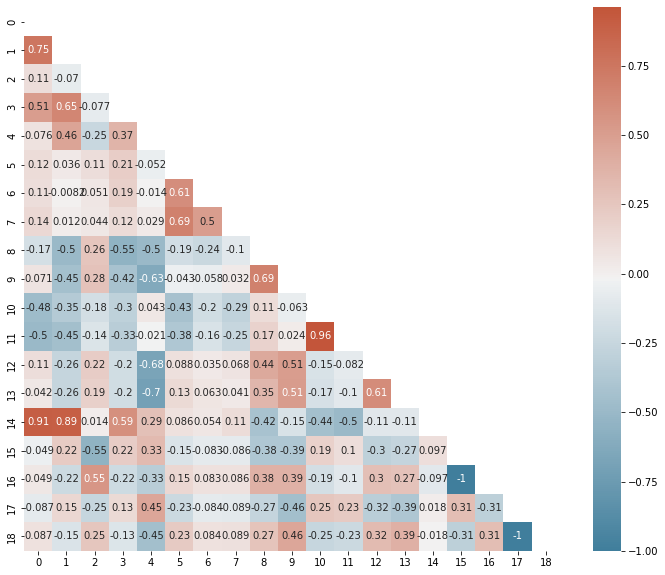

In [25]:

f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, mask = mask, cmap=cmap)

Ideally we should remove one of the higly correlated feature or combine those together. For the time being we doing neither. 

## Principal Component Analysis

In [26]:

pca = PCA(n_components=3)
pca.fit(ddf_features_norm.to_dask_array(lengths=True))
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None, svd_solver='auto', tol=0.0, whiten=False)


PCA(iterated_power='auto', n_components=3)

In [27]:
pca.fit_transform(ddf_features_norm.to_dask_array(lengths=True))

dask.array<mul, shape=(56420, 3), dtype=float64, chunksize=(56420, 3), chunktype=numpy.ndarray>

In [28]:
pca.get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [29]:
print(pca.explained_variance_ratio_) 

[0.28446169 0.22573935 0.10772273]


In [30]:
pca.components_

array([[-1.09450104e-01, -2.89157519e-01,  1.86381155e-01,
        -2.56730854e-01, -3.41587561e-01,  2.48311757e-02,
        -5.76861193e-03,  6.17338609e-03,  3.19165424e-01,
         3.33569571e-01,  3.95612243e-04,  4.19304259e-02,
         2.75802519e-01,  2.75769084e-01, -2.11523055e-01,
        -2.68501179e-01,  2.68501179e-01, -2.55394764e-01,
         2.55394764e-01],
       [ 3.58820536e-01,  2.65302040e-01,  1.43490952e-01,
         2.34951931e-01, -3.55876935e-02,  2.72903212e-01,
         1.84842136e-01,  2.12991724e-01, -9.60177477e-02,
         4.47060403e-02, -3.95534158e-01, -3.90000702e-01,
         1.01635441e-01,  1.09003617e-01,  3.33954396e-01,
        -1.38331761e-01,  1.38331761e-01, -1.97511459e-01,
         1.97511459e-01],
       [-2.98598924e-01, -2.58707840e-01, -7.42222144e-02,
        -2.93954742e-02,  5.51614618e-02,  4.96333572e-01,
         4.83795442e-01,  4.65914032e-01, -1.54193398e-01,
        -1.42838226e-01,  1.32225523e-03,  3.71399752e-02,
    

# Cross validation
Cross-validation is a method for evaluating ML models by training several ML models on subsets of the data and evaluating another subset of the data. The advantages of cross validation are : 

1. Identify Overfitting
2. Comparison between different models 
3. Hyperparameter tuning
4. Efficiency : Allows the use of data for both training and validation

In [31]:
#Divide into learning and test set

X_train, X_test, y_train, y_test = train_test_split(ddf_features_norm, ddf_target, shuffle=False)

In [32]:
X_train.compute().head()
X_test.compute().head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,RainToday_No,RainToday_Yes,RainTomorrow_No,RainTomorrow_Yes
6075,2.109398,2.077406,-0.303702,2.352889,1.400800,0.384146,1.001905,-1.502541,-1.127531,-1.366647,-0.295183,-0.319551,-1.158937,-0.501096,1.643598,0.532445,-0.532445,0.531485,-0.531485
6085,2.436672,2.766011,-0.303702,2.028236,1.161319,-0.965674,-0.801645,-0.797496,-2.207846,-1.663723,-1.409624,-1.396568,-1.158937,-0.878850,2.648480,0.532445,-0.532445,0.531485,-0.531485
6092,0.519779,-0.131869,-0.218168,0.675513,-1.446368,1.658976,2.324508,1.787666,0.006799,0.168245,-0.497808,-0.377768,0.986113,1.009919,0.044921,0.532445,-0.532445,-1.881519,1.881519
6105,0.691208,1.374455,-0.303702,0.783731,1.134709,-1.265633,-0.320699,-1.502541,-2.207846,-1.515185,-0.367549,-0.261334,-1.516445,-1.256603,0.882323,0.532445,-0.532445,0.531485,-0.531485
6106,1.002898,1.331417,-0.303702,1.000166,1.214537,-0.140784,1.242378,-1.502541,-0.587374,-1.366647,-0.396496,-0.450539,-1.158937,-1.256603,0.653941,0.532445,-0.532445,0.531485,-0.531485


In [33]:
y_train.compute().head()
y_test.compute().head()

6075    36.4
6085    41.4
6092    22.4
6105    32.4
6106    32.3
Name: Temp3pm, dtype: float64

In [34]:
y_train_array = y_train.to_dask_array(lengths=True)
X_train_array = X_train.to_dask_array(lengths=True)

In [35]:
X_train_array

dask.array<values, shape=(50716, 19), dtype=float64, chunksize=(50716, 19), chunktype=numpy.ndarray>

# Linear Regression

Linear regression tries to find the optimal W<sub>1</sub>, W<sub>2</sub>, W<sub>3</sub>, W<sub>4</sub>, so that we can predict the value of Y for the user-supplied X<sub>1</sub>, X<sub>2</sub>, X<sub>3</sub>.

$$
  Y(X_1, X_2, X_3) = W_1 * X_1 + W_2 * X_2 + W_3 * X_3 + W_4
$$

In [36]:
lr = LinearRegression(solver_kwargs={"normalize":False})

In [37]:
lr.fit(X_train_array, y_train_array)

LinearRegression(solver_kwargs={'normalize': False})

In [38]:
y_test_array = y_test.to_dask_array(lengths=True)
X_test_array = X_test.to_dask_array(lengths=True)

In [39]:
print(lr.score(X_test_array, y_test_array))

0.9821466190574927


In [40]:
predicted_value = lr.predict(X_test_array[0, :].reshape(1, 19))

In [41]:
predicted_value.compute()

array([36.7039045])

In [42]:
original_value = y_test_array[0]

In [43]:
original_value.compute()

36.4

# K-Means Clustering

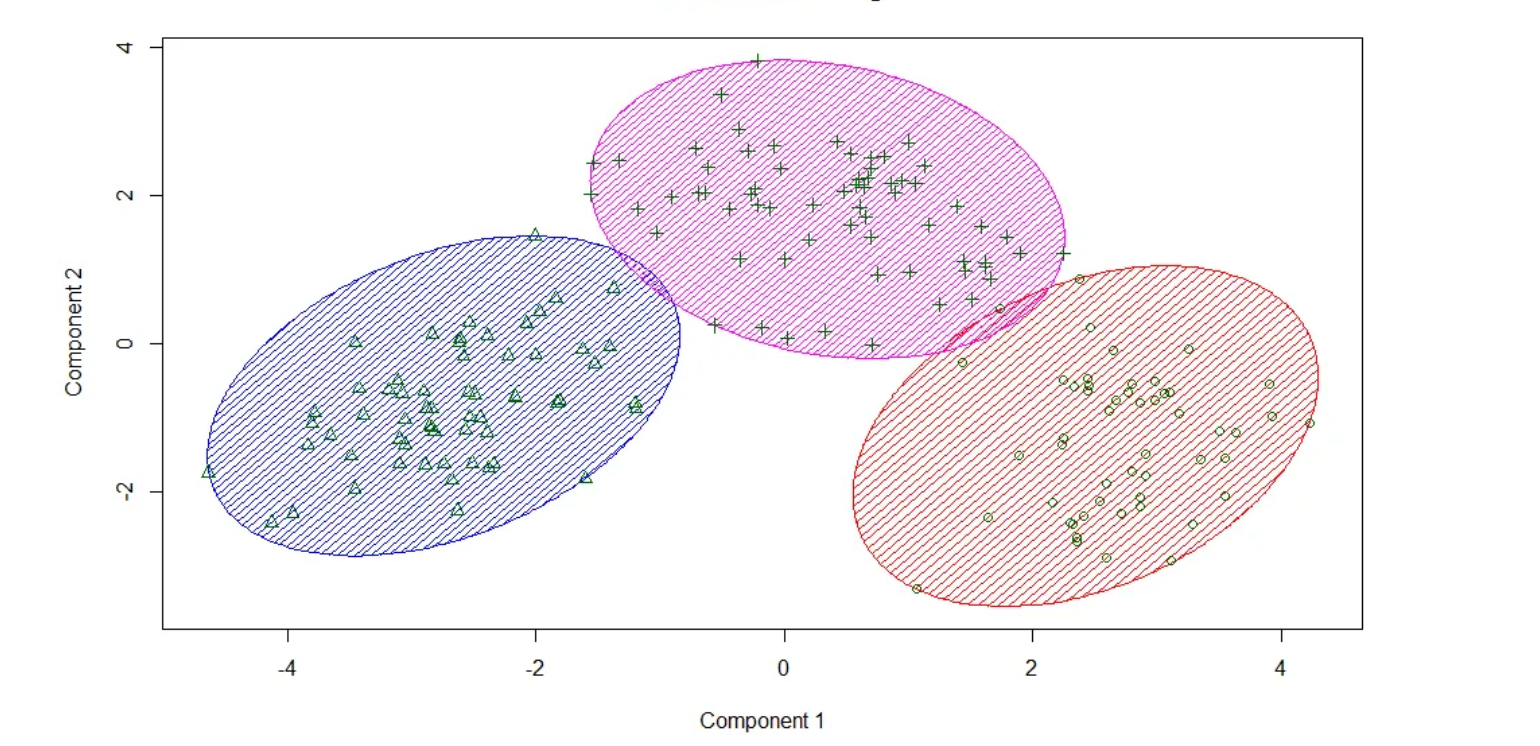

In [44]:
from IPython.display import Image
Image("./k-means.png")
# Image is from https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a

* Unsupervised machine learning
* Finds subgroups within a data
* A data point can sometime fall under more than one subgroup

In [45]:
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names




<Axes: xlabel='Longitude', ylabel='Latitude'>

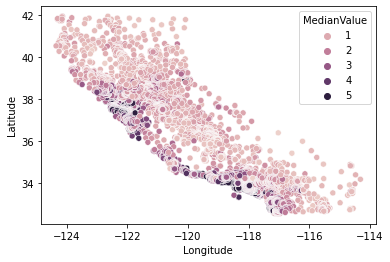

In [46]:
mat = np.column_stack((X, y))
df = pd.DataFrame(mat, columns=np.append(feature_names, 'MedianValue'))
sns.scatterplot(data = df, x = 'Longitude', y = 'Latitude', hue = 'MedianValue')

In [47]:
ddf = dd.from_pandas(df, npartitions=10).dropna()
ddf.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [48]:
# cross validation
ddf_features = ddf.drop(columns=['MedianValue'])
ddf_target = ddf[['MedianValue']]

X_train, X_test, y_train, y_test = train_test_split(ddf_features, ddf_target, test_size=0.2, shuffle='False')

In [49]:
# normalization

scaler = StandardScaler()
ddf_features_norm = scaler.fit_transform(ddf_features)

In [50]:
kmeans = KMeans(n_clusters=4, init_max_iter=1, oversampling_factor=8)

In [51]:
kmeans.fit(ddf_features_norm)

KMeans(init_max_iter=1, n_clusters=4, oversampling_factor=8)

In [52]:
kmeans.labels_

dask.array<astype, shape=(20640,), dtype=int32, chunksize=(2064,), chunktype=numpy.ndarray>

<Axes: xlabel='Longitude', ylabel='Latitude'>

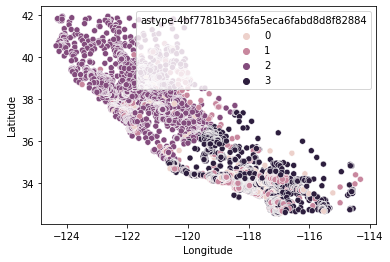

In [53]:
sns.scatterplot(data = ddf, x = 'Longitude', y = 'Latitude', hue = kmeans.labels_)

## Exercise
1. Test the result without data normalization
2. Apply other data preprocessing to the data
3. Change the number of clusters

# Pipelining
We saw that an ML workflow involves multiple stages. We can combine multiple stages of this workflow into a single pipeline. This is especially useful when your model is iterative. 

In [54]:
pipe = Pipeline([('reduce_dim', PCA()), 
                 ('cluster', KMeans(n_clusters = 3, random_state = 0, n_init='auto'))
                ])

In [55]:
pipe

Pipeline(steps=[('reduce_dim', PCA()),
                ('cluster', KMeans(n_clusters=3, random_state=0))])

In [56]:
kmeans = pipe.fit(X_train.to_dask_array(lengths=True))

<Axes: xlabel='Longitude', ylabel='Latitude'>

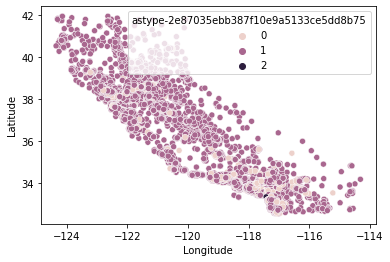

In [57]:
sns.scatterplot(data = X_train, x = 'Longitude', y = 'Latitude', hue = pipe['cluster'].labels_)

# Excersice
1. Add normalization to the pipeline

In [4]:
!ls ACT_weather_data/IDCJAC0009_070011_1800

IDCJAC0009_070011_1800_Data.csv  IDCJAC0009_070011_1800_Note.txt


In [3]:
df = pd.read_csv('ACT_weather_data/IDCJAC0009_070011_1800/IDCJAC0009_070011_1800_Data.csv')

In [4]:
df.tail()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
47476,IDCJAC0009,70011,2019,12,27,0.0,NaN,Y
47477,IDCJAC0009,70011,2019,12,28,0.0,NaN,Y
47478,IDCJAC0009,70011,2019,12,29,0.0,NaN,Y
47479,IDCJAC0009,70011,2019,12,30,0.0,NaN,Y
47480,IDCJAC0009,70011,2019,12,31,0.0,NaN,Y


In [5]:
ddf = dd.from_pandas(df, npartitions=10).dropna()
ddf.head()

,Product code,Bureau of Meteorology station number,Year,Month,Day,Rainfall amount (millimetres),Period over which rainfall was measured (days),Quality
99,IDCJAC0009,70011,1890,4,10,2.0,1.0,Y
100,IDCJAC0009,70011,1890,4,11,1.3,1.0,Y
124,IDCJAC0009,70011,1890,5,5,0.5,1.0,Y
125,IDCJAC0009,70011,1890,5,6,1.0,1.0,Y
136,IDCJAC0009,70011,1890,5,17,4.8,1.0,Y


In [6]:
ddf.columns

Index(['Product code', 'Bureau of Meteorology station number', 'Year', 'Month',
       'Day', 'Rainfall amount (millimetres)',
       'Period over which rainfall was measured (days)', 'Quality'],
      dtype='object')

<Axes: xlabel='Month', ylabel='Day'>

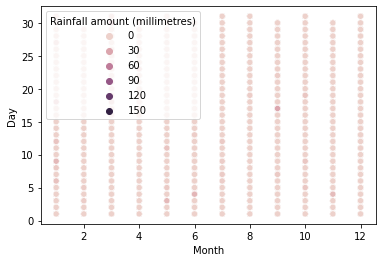

In [7]:
sns.scatterplot(data = df, x = 'Month', y = 'Day', hue = 'Rainfall amount (millimetres)')